In [ ]:
import numpy as np
import tensorflow as tf
import random
import gym
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
ENV_CONFIG = {
    "num_iot": 5,
    "num_uavs": 3,
    "num_clouds": 2,
    "master_uav_cpu": 15.0,  # GHz
    "master_battery": 100.0,  # Initial battery (%)
    "max_task_size": 2.0,     # Max task size (MB)
}

In [ ]:
class MasterUAVEnvironment(gym.Env):
    def __init__(self):
        super().__init__()
        self._initialize_resources()

        # Define action and observation spaces
        self.action_space = gym.spaces.Discrete(4)  # Actions: [Local, IoT, UAV, Cloud]

        # Dynamically calculate observation space shape
        dummy_state = self._get_state()
        self.observation_space = gym.spaces.Box(
            low=0, high=100, shape=dummy_state.shape, dtype=np.float32
        )

    def _initialize_resources(self):
        """Initialize computational resources and bandwidth"""
        self.iot_cpu = np.random.uniform(1, 3, ENV_CONFIG["num_iot"])
        self.uav_cpu = np.random.uniform(5, 10, ENV_CONFIG["num_uavs"])
        self.cloud_cpu = np.full(ENV_CONFIG["num_clouds"], 50.0, dtype=np.float32)
        self.bandwidth = np.random.uniform(1, 5, ENV_CONFIG["num_uavs"] + ENV_CONFIG["num_clouds"])
        self.master_battery = ENV_CONFIG["master_battery"]
        self.task_size = 0.0
        self.computation_needed = 0.0

    def reset(self):
        """Reset environment to initial state"""
        self._initialize_resources()
        return self._get_state()

    # ========== STATE MANAGEMENT ========== #
    def _get_state(self):
        """Generate normalized state vector"""
        state = np.concatenate([
            [self.master_battery, ENV_CONFIG["master_uav_cpu"],
             self.task_size, self.computation_needed],
            self.iot_cpu,
            self.uav_cpu,
            self.cloud_cpu,
            self.bandwidth
        ], dtype=np.float32)
        return state

    def _can_execute_locally(self):
        """Check if Master UAV can process task locally"""
        required_energy = self.task_size * self.computation_needed * 0.05 * (ENV_CONFIG["master_uav_cpu"]**2)
        required_time = (self.task_size * self.computation_needed) / ENV_CONFIG["master_uav_cpu"]
        return (self.master_battery >= required_energy) and (required_time <= 5.0)

    # ========== STEP & OFFLOADING LOGIC ========== #
    def step(self, action):
        # Generate new task
        self.task_size = np.random.uniform(0.5, ENV_CONFIG["max_task_size"])
        self.computation_needed = np.random.uniform(5, 15)

        reward = 0.0
        done = False

        if self._can_execute_locally():
            # Local execution
            processing_time = (self.task_size * self.computation_needed) / ENV_CONFIG["master_uav_cpu"]
            energy_consumed = self.task_size * self.computation_needed * 0.05 * (ENV_CONFIG["master_uav_cpu"]**2)
            self.master_battery -= energy_consumed
            reward = - (processing_time + energy_consumed)
            """update reward"""
            reward = self._apply_reward_shaping(reward, processing_time, energy_consumed, is_local=True)
        else:
            # Offload to external nodes
            total_time, total_energy = self._calculate_offload_metrics(action)
            reward = - (total_time + total_energy)
            """update reward"""
            reward = self._apply_reward_shaping(reward, total_time, total_energy, is_local=False)



        # Update dynamic resources
        self._update_resources()
        return self._get_state(), reward, done, {}

    def _calculate_offload_metrics(self, action):
        """Calculate metrics for offloading actions"""
        if action == 0:  # IoT
            idx = np.random.randint(ENV_CONFIG["num_iot"])
            power = 0.4
            transmission_rate = 1.5
            cpu_speed = self.iot_cpu[idx]
        elif action == 1:  # UAV
            idx = np.random.randint(ENV_CONFIG["num_uavs"])
            power = 0.6
            transmission_rate = self.bandwidth[idx]
            cpu_speed = self.uav_cpu[idx]
        else:  # Cloud
            idx = np.random.randint(ENV_CONFIG["num_clouds"])
            power = 0.8
            transmission_rate = self.bandwidth[ENV_CONFIG["num_uavs"] + idx]
            cpu_speed = self.cloud_cpu[idx]

        tx_time = self.task_size / transmission_rate
        tx_energy = (self.task_size * power) / transmission_rate
        proc_time = (self.task_size * self.computation_needed) / cpu_speed
        proc_energy = self.task_size * self.computation_needed * 0.02 * (cpu_speed**2)
        return tx_time + proc_time, tx_energy + proc_energy

    def _apply_reward_shaping(self, reward, processing_time, energy_consumed, is_local=False):
        shaped = reward
        if processing_time < 2.0:     # encourage faster tasks
            shaped += 1
        if is_local and energy_consumed < 150.0:  # reasonable for UAV local exec
            shaped += 1
        elif not is_local and energy_consumed < 400.0:  # reasonable for IoT/UAV/Cloud
            shaped += 1
        return shaped

    def _update_resources(self):
        """Simulate dynamic resource changes"""
        self.iot_cpu = np.clip(self.iot_cpu + np.random.normal(0, 0.1, ENV_CONFIG["num_iot"]), 1, 3)
        self.uav_cpu = np.clip(self.uav_cpu + np.random.normal(0, 0.2, ENV_CONFIG["num_uavs"]), 5, 10)
        self.bandwidth = np.clip(self.bandwidth + np.random.normal(0, 0.1, len(self.bandwidth)), 1, 5)

In [ ]:
class DRLAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        """Build model with explicit Input layer"""
        model = Sequential([
            tf.keras.layers.Input(shape=(self.state_size,)),  # Explicit input layer
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state.reshape(1, -1), verbose=0)  # Fix: Reshape for prediction
        return np.argmax(act_values[0])

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        states = np.array([transition[0] for transition in minibatch])
        next_states = np.array([transition[3] for transition in minibatch])

        # Predict Q-values for current and next states
        targets = self.model.predict(states, verbose=0)
        next_q_values = self.model.predict(next_states, verbose=0)

        # Update targets
        for i, (_, action, reward, _, done) in enumerate(minibatch):
            if done:
                targets[i][action] = reward
            else:
                targets[i][action] = reward + self.gamma * np.max(next_q_values[i])

        # Train the model
        self.model.fit(states, targets, epochs=1, verbose=0)
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

In [ ]:
def train_agent(episodes=500):
    env = MasterUAVEnvironment()
    agent = DRLAgent(env.observation_space.shape[0], env.action_space.n)
    rewards_history = []

    for episode in range(episodes):
        state = env.reset()  # Shape: (state_size,)
        total_reward = 0

        for _ in range(100):
            # Reshape state for prediction (1D -> 2D)
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)

            agent.remember(state, action, reward, next_state, done)
            state = next_state  # Keep as 1D array
            total_reward += reward

            if done:
                break

        agent.replay()
        rewards_history.append(total_reward)
        print(f"Episode {episode+1}: Reward={total_reward:.2f}, ε={agent.epsilon:.3f}")

    return agent, rewards_history

In [ ]:
# =============================================
# New Block 6: Testing Function
# =============================================
def test_agent(agent, test_episodes=100):
    env = MasterUAVEnvironment()
    test_rewards = []

    # Disable exploration during testing
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0

    for episode in range(test_episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(100):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward
            if done: break

        test_rewards.append(total_reward)
        print(f"Test Episode {episode+1}: Reward={total_reward:.2f}")

    # Restore original epsilon
    agent.epsilon = original_epsilon
    return test_rewards

In [ ]:

# =============================================
# New Block 7: Combined Visualization
# =============================================
def visualize_results(train_rewards, test_rewards):
    plt.figure(figsize=(12, 5))

    # Training Performance
    plt.subplot(1, 2, 1)
    plt.plot(train_rewards, color='blue', label='Training')
    plt.title("Training Performance")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()

    # Testing Performance
    plt.subplot(1, 2, 2)
    plt.plot(test_rewards, color='green', label='Testing')
    plt.title("Testing Performance")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

Episode 1: Reward=-28594.34, ε=0.995
Episode 2: Reward=-27021.02, ε=0.990
Episode 3: Reward=-22176.50, ε=0.985
Episode 4: Reward=-32104.85, ε=0.980
Episode 5: Reward=-27134.21, ε=0.975
Episode 6: Reward=-32857.93, ε=0.970
Episode 7: Reward=-27593.56, ε=0.966
Episode 8: Reward=-35510.79, ε=0.961
Episode 9: Reward=-33004.90, ε=0.956
Episode 10: Reward=-26072.77, ε=0.951
Episode 11: Reward=-32510.47, ε=0.946
Episode 12: Reward=-33068.53, ε=0.942
Episode 13: Reward=-33231.14, ε=0.937
Episode 14: Reward=-37790.52, ε=0.932
Episode 15: Reward=-34800.25, ε=0.928
Episode 16: Reward=-29293.07, ε=0.923
Episode 17: Reward=-27254.71, ε=0.918
Episode 18: Reward=-34405.98, ε=0.914
Episode 19: Reward=-32875.25, ε=0.909
Episode 20: Reward=-27781.75, ε=0.905
Episode 21: Reward=-31729.86, ε=0.900
Episode 22: Reward=-30641.56, ε=0.896
Episode 23: Reward=-26849.43, ε=0.891
Episode 24: Reward=-27415.38, ε=0.887
Episode 25: Reward=-33450.21, ε=0.882
Episode 26: Reward=-28726.25, ε=0.878
Episode 27: Reward=-3

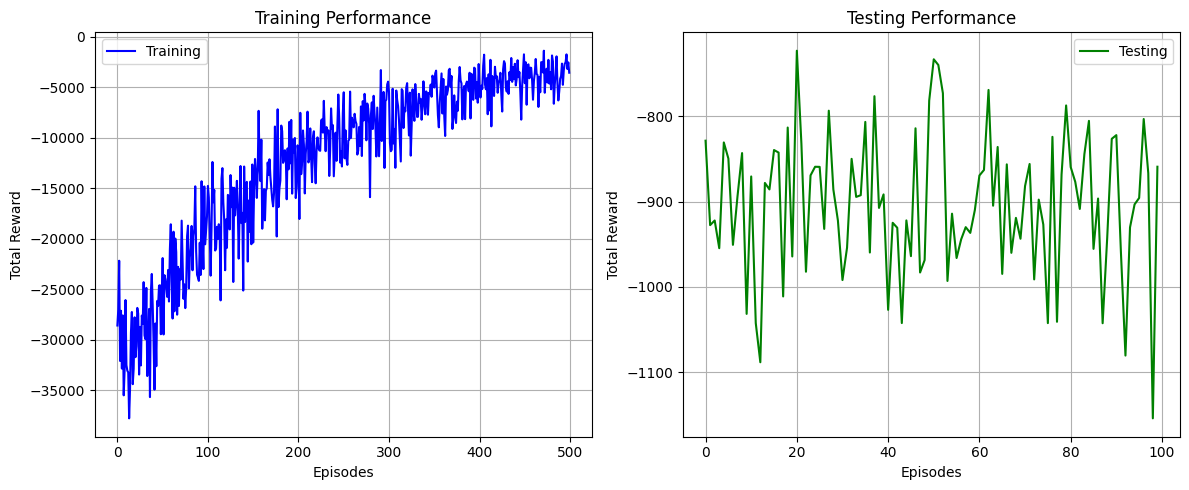

Training and testing completed!


In [ ]:
# =============================================
# Main Execution Block (Updated)
# =============================================
if __name__ == "__main__":
    # Training Phase
    trained_agent, train_rewards = train_agent(episodes=500)

    # Testing Phase
    test_rewards = test_agent(trained_agent, test_episodes=100)

    # Visualization
    visualize_results(train_rewards, test_rewards)

    # Save Model
    trained_agent.model.save("master_uav_drl_trained.h5")
    print("Training and testing completed!")